In [2]:
from graphviz import Digraph
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import pylab
import copy
from collections.abc import Callable

In [3]:
class Vertex:
    """
    Vertex class
    """

    def __init__(self, name: str):
        """
        Constructor for the Vertex class
        """
        self.name = name
        self.parents = (
            set()
        )  # set consisting of Vertex objects that are parents of this vertex
        self.children = (
            set()
        )  # set consisting of Vertex objects that are children of this vertex


class CausalDAG:
    """
    DAG class
    """

    def __init__(self, vertex_names: list[str], edges: list[(str, str)]) -> None:
        """
        Constructor for the causal DAG class
        """

        self.vertices = {
            v: Vertex(v) for v in vertex_names
        }  # dictionary mapping vertex names to Vertex objects
        self.edges = []  # list of tuples corresponding to edges in the DAG

        # loop over and initialize all vertices to have parent-child relations specified by the edges
        for parent_name, child_name in edges:
            self.edges.append((parent_name, child_name))
            # get the corresponding vertex objects
            parent_vertex = self.vertices.get(parent_name)
            child_vertex = self.vertices.get(child_name)
            # add to the parent/child sets
            parent_vertex.children.add(child_vertex)
            child_vertex.parents.add(parent_vertex)

    def get_parents(self, vertex_name: str) -> list[str]:
        """
        Returns a list of names of the parents
        """
        return [p.name for p in self.vertices[vertex_name].parents]

    def get_children(self, vertex_name: str) -> list[str]:
        """
        Returns a list of names of the parents
        """
        return [c.name for c in self.vertices[vertex_name].children]

    def get_descendants(self, vertex_name: str) -> list[str]:
        """
        Returns a list of strings corresponding to descendants of the given vertex.
        Note by convention, the descendants of a vertex include the vertex itself.
        """

        stack = [vertex_name]
        visited = set()

        while len(stack) > 0:

            v_name = stack.pop()
            if v_name in visited:
                continue
            visited.add(v_name)
            stack += self.get_children(v_name)

        return list(visited)

    def d_separated(self, x_name: str, y_name: str, z_names: list[str]) -> bool:
        """
        Check if X _||_ Y | Z using d-separation
        """

        stack = [(x_name, "up")]  # stack for vertices to be explored next
        visited = (
            set()
        )  # set of (vertex, direction) pairs that have already been explored

        while len(stack) > 0:

            v_name, direction = stack.pop()

            if (v_name, direction) in visited:
                continue

            # we reached Y through an open path so return False
            if v_name == y_name:
                return False

            visited.add((v_name, direction))

            # cases for active forks and chain
            if direction == "up" and v_name not in z_names:

                for child in self.get_children(v_name):
                    stack.append((child, "down"))
                for parent in self.get_parents(v_name):
                    stack.append((parent, "up"))

            # cases for active chain and colliders
            elif direction == "down":

                if v_name not in z_names:
                    for child in self.get_children(v_name):
                        stack.append((child, "down"))

                if len(set(self.get_descendants(v_name)).intersection(z_names)) != 0:
                    for parent in self.get_parents(v_name):
                        stack.append((parent, "up"))

        return True

    def valid_backdoor_set(self, a_name: str, y_name: str, z_names: list[str]) -> bool:
        """
        Check if Z is a valid backdoor set for computing the effect of A on Y
        """

        # check the descendants criterion
        descendants_a = self.get_descendants(a_name)
        if len(set(descendants_a).intersection(z_names)) != 0:
            return False

        # check d-sep criterion in graph where we remove outgoing edges A->o
        edges = []
        for edge in self.edges:
            if edge[0] != a_name:
                edges.append(edge)

        G_Abar = CausalDAG(self.vertices, edges)
        return G_Abar.d_separated(a_name, y_name, z_names)

    def draw(self):
        """
        Method for visualizing the DAG
        """

        dot = Digraph()
        dot.graph_attr["rankdir"] = "LR"

        for v_name in self.vertices:
            dot.node(
                v_name,
                shape="plaintext",
                height=".5",
                width=".5",
            )

        for parent, child in self.edges:
            dot.edge(parent, child, color="blue")

        return dot


def fit_backdoor_model(
    data: pd.DataFrame, a_name: str, y_name: str, z_names: list[str]
):
    """
    ANGUS: helper function for code reuse
    """
    # make a regression formula
    z_names = ["1"] + z_names
    z_formula = " + ".join(z_names)
    regression_formula = f"{y_name} ~ {z_formula} + {a_name}"

    # fit a regression depending on whether Y is binary or not
    if set(data[y_name]) == {0, 1}:
        model = smf.glm(
            formula=regression_formula, family=sm.families.Binomial(), data=data
        ).fit()
    else:
        model = smf.glm(
            formula=regression_formula, family=sm.families.Gaussian(), data=data
        ).fit()

    return model


def backdoor_adjustment(
    data: pd.DataFrame, a_name: str, y_name: str, z_names: list[str]
) -> float:
    """
    Perform backdoor adjustment for a given treatment A and outcome Y using
    the covariates in Z
    """
    model = fit_backdoor_model(data, a_name, y_name, z_names)

    data_a1 = data.copy()  # make a copy for the interventional datasets
    data_a1[a_name] = 1
    data_a0 = data.copy()
    data_a0[a_name] = 0

    return round(np.mean(model.predict(data_a1) - model.predict(data_a0)), 3)


def fit_ipw_model(data: pd.DataFrame, a_name: str, y_name: str, z_names: list[str]):
    """
    ANGUS: helper function for code reuse
    """
    # fit a binomial regression to find p(A | Z)
    z_names = ["1"] + z_names
    z_formula = " + ".join(z_names)
    regression_formula = f"{a_name} ~ {z_formula}"
    model = smf.glm(
        formula=regression_formula, family=sm.families.Binomial(), data=data
    ).fit()
    return model


def ipw(data: pd.DataFrame, a_name: str, y_name: str, z_names: list[str]) -> float:
    """
    Perform IPW for a given treatment A and outcome Y using
    the covariates in Z
    """
    model = fit_ipw_model(data, a_name, y_name, z_names)

    p_a1_z = model.predict(data)
    p_a0_z = 1 - p_a1_z

    # I(A_i = 1) is the same as data[a_name]
    e_ya1 = np.mean((data[a_name] / p_a1_z) * data[y_name])
    e_ya0 = np.mean(((1 - data[a_name]) / p_a0_z) * data[y_name])

    return round(e_ya1 - e_ya0, 3)


def augmented_ipw(
    data: pd.DataFrame, a_name: str, y_name: str, z_names: list[str]
) -> float:
    """
    Perform AIPW for a given treatment A and outcome Y using
    the covariates in Z
    """
    backdoor_model = fit_backdoor_model(data, a_name, y_name, z_names)
    ipw_model = fit_ipw_model(data, a_name, y_name, z_names)

    e_y_given_ac = backdoor_model.predict(data)

    p_a1_z = ipw_model.predict(data)
    p_a0_z = 1 - p_a1_z

    data_a1 = data.copy()  # make a copy for the interventional datasets
    data_a1[a_name] = 1
    data_a0 = data.copy()
    data_a0[a_name] = 0

    # E[Y^a1] = E[(I[A=1]/P(A=1|Z)) * (Y-E[Y|A,Z]) + E[Y|A=1, Z]]
    e_ya1 = np.mean(
        (data[a_name] / p_a1_z) * (data[y_name] - e_y_given_ac)
        + backdoor_model.predict(data_a1)
    )
    # E[Y^a0] = E[(I[A=0]/P(A=0|Z)) * (Y-E[Y|A,Z]) + E[Y|A=0, Z]]
    e_ya0 = np.mean(
        ((1 - data[a_name]) / p_a0_z) * (data[y_name] - e_y_given_ac)
        + backdoor_model.predict(data_a0)
    )

    return round(e_ya1 - e_ya0, 3)


def compute_confidence_intervals(
    data: pd.DataFrame,
    a_name: str,
    y_name: str,
    z_names: list[str],
    estimator: Callable,
    num_bootstraps: int = 200,
    alpha: float = 0.05,
) -> tuple[float, float]:
    """
    Compute confidence intervals for a given estimator via bootstrap

    Returns tuple (q_low, q_up) for the lower and upper quantiles of the confidence interval.
    """

    Ql = alpha / 2
    Qu = 1 - alpha / 2
    estimates = []

    for i in range(num_bootstraps):

        # resample the data with replacement
        data_sampled = data.sample(len(data), replace=True)
        data_sampled.reset_index(drop=True, inplace=True)

        # add estimate from resampled data
        estimates.append(estimator(data_sampled, a_name, y_name, z_names))

    # calculate the quantiles
    quantiles = np.quantile(estimates, q=[Ql, Qu])
    q_low = quantiles[0]
    q_up = quantiles[1]
    return round(q_low, 3), round(q_up, 3)

In [4]:
vertices = set()
edges = []

# Quick parser to get vertices and edges
with open("pytetrad/PROJECT_learned_edges.txt") as f:
    lines = f.readlines()
    for line in lines[4:91]:
        split = line.split()
        # Skip undirected edges (Only undirected edges age --- gender)
        if split[2] == "---":
            continue
        vertices.add(split[1])
        vertices.add(split[3])
        edges.append((split[1], split[3]))

dag = CausalDAG(list(vertices), edges)

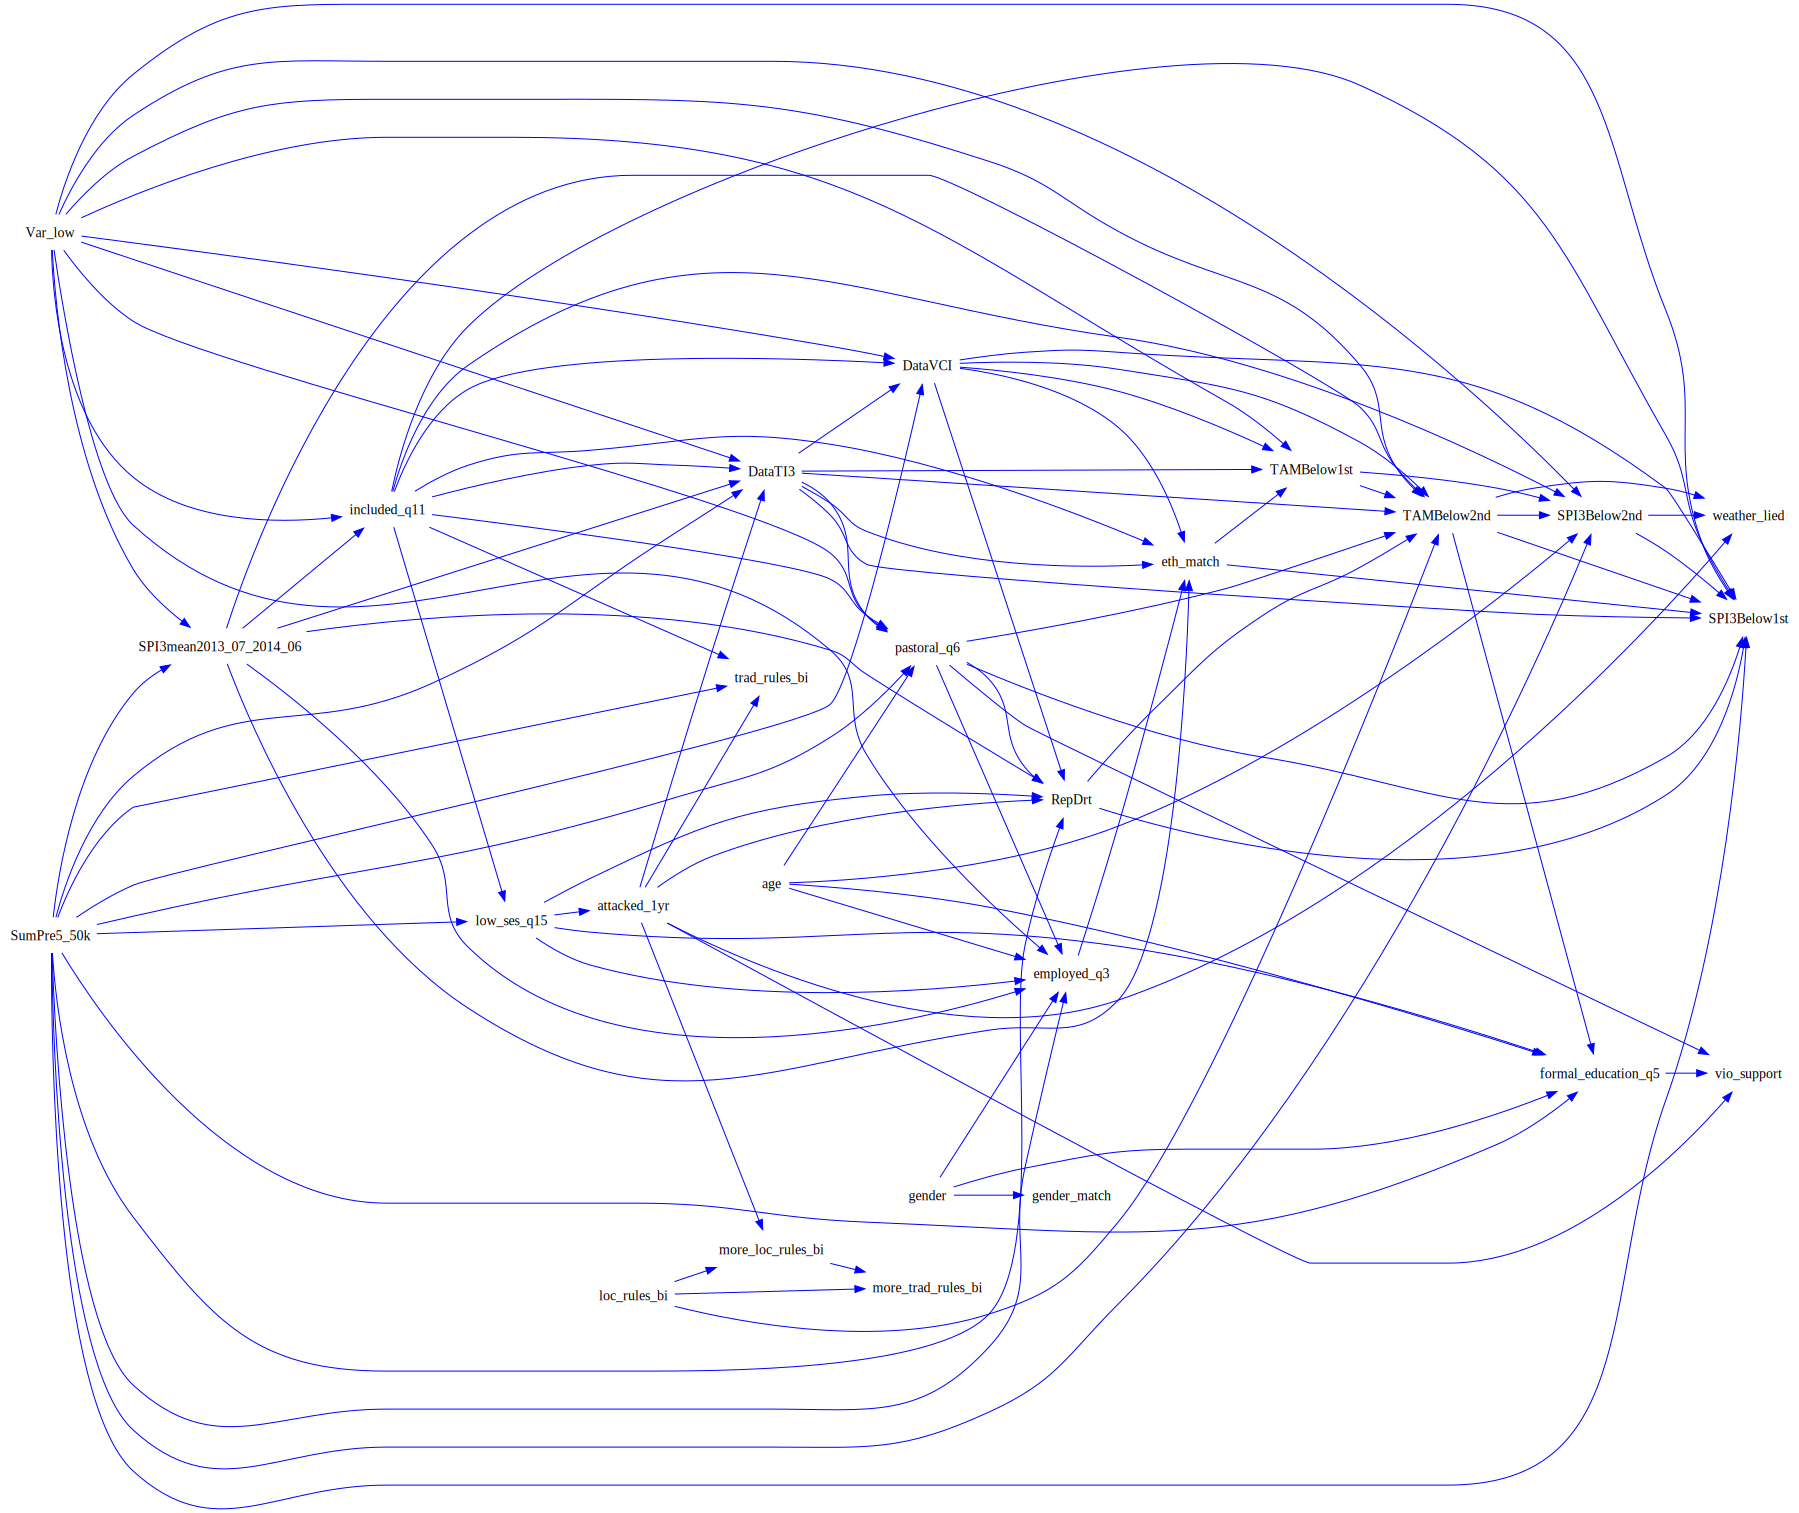

In [5]:
image = dag.draw() # DAG.png
image